In [15]:
# Import packages
import datetime
import geopandas as gpd
import holidays
# import july
import numpy as np
import os
import pandas as pd
from matplotlib import pyplot as plt
from dbfread import DBF
# import seaborn as sns
import shutil
import time
# Import CEA modules
import cea.config
import cea.api 
from cea.utilities.dbf import *
from cea.utilities.epwreader import epw_reader
from cea.datamanagement.archetypes_mapper import archetypes_mapper
from cea.demand.schedule_maker.schedule_maker import main as schedule_maker
from cea.demand.demand_main import main as demand_main
from cea.resources.radiation.main import main as radiation_main


DAYSIM_BIN_DIRECTORY = os.path.join(os.getcwd(), 'CEA_model/0_daysim_binaries/darwin')
project_folder = os.path.join(os.getcwd(), 'CEA_model')



In [14]:
zone_gdf = gpd.read_file(
    os.path.join(project_folder, 'Block0202023', '2020', 'inputs', 'building-geometry', 'zone.shp')) 
list_buildings = zone_gdf["Name"].tolist() 
import cea.config
config = cea.config.Configuration()
config.multiprocessing = True

In [12]:
archetypes = ["AB_E" , "AB_E_NR", "AB_E_AR"] 
years = ["2020", "2021", "2022"]

In [16]:

for archetype in archetypes:
    for year in years: 
        path_to_new_scenario = os.path.join(project_folder, 'Block0202023', f'{year}_{archetype}') # create the destination path for copying the baseline scenario
        path_to_baseline = os.path.join(project_folder, 'Block0202023', year)
        try:
            shutil.copytree(path_to_baseline, path_to_new_scenario)
        except WindowsError:
            pass 
        archetype_path = os.path.join(project_folder, 'Block0202023', f'{year}_{archetype}', "inputs", "building-properties", "typology.dbf")
        archetype_file = gpd.read_file(archetype_path)
        archetype_file["STANDARD"] = archetype
        archetype_file.to_file(archetype_path)
        config.scenario_name = f'{year}_{archetype}'
        config.archetypes_mapper.buildings = list_buildings
        archetypes_mapper(locator=cea.inputlocator.InputLocator(config.scenario), 
                      update_architecture_dbf=True, update_air_conditioning_systems_dbf=True, 
                      update_indoor_comfort_dbf=True, update_internal_loads_dbf=True,
                      update_supply_systems_dbf=True, update_schedule_operation_cea=True, 
                      buildings=list_buildings)
        config.schedule_maker.buildings = list_buildings 
        schedule_maker(config) 
        radiation_main(config)
        config.demand.buildings = list_buildings
        demand_main(config) 

Running occupancy model for scenario C:\Users\felix\Programmieren\cea_berlin\CEA_model\Block0202023\2020_AB_E
Running occupancy model  with schedule model=deterministic
Using 11 CPU's
Schedule for building No. 1 completed out of 6: B1005
Schedule for building No. 2 completed out of 6: B1002
Schedule for building No. 3 completed out of 6: B1003
Schedule for building No. 4 completed out of 6: B1001
Schedule for building No. 5 completed out of 6: B1004
Schedule for building No. 6 completed out of 6: B1000
Using Daysim binaries from path: c:\users\felix\documents\cityenergyanalyst\dependencies\daysim\bin
Using Daysim data from path: c:\users\felix\documents\cityenergyanalyst\dependencies\daysim\lib
verifying geometry files
zone: C:\Users\felix\Programmieren\cea_berlin\CEA_model\Block0202023\2020_AB_E\inputs\building-geometry\zone.shp
surroundings: C:\Users\felix\Programmieren\cea_berlin\CEA_model\Block0202023\2020_AB_E\inputs\building-geometry\surroundings.shp
Getting geometry materials
Cr

{'QH_sys_MWhyr': {2020: 704.2760000000001, 2021: 863.5259999999998, 2022: 741.708}, 'E_sys_MWhyr': {2020: 475.39300000000003, 2021: 476.29599999999994, 2022: 476.942}}


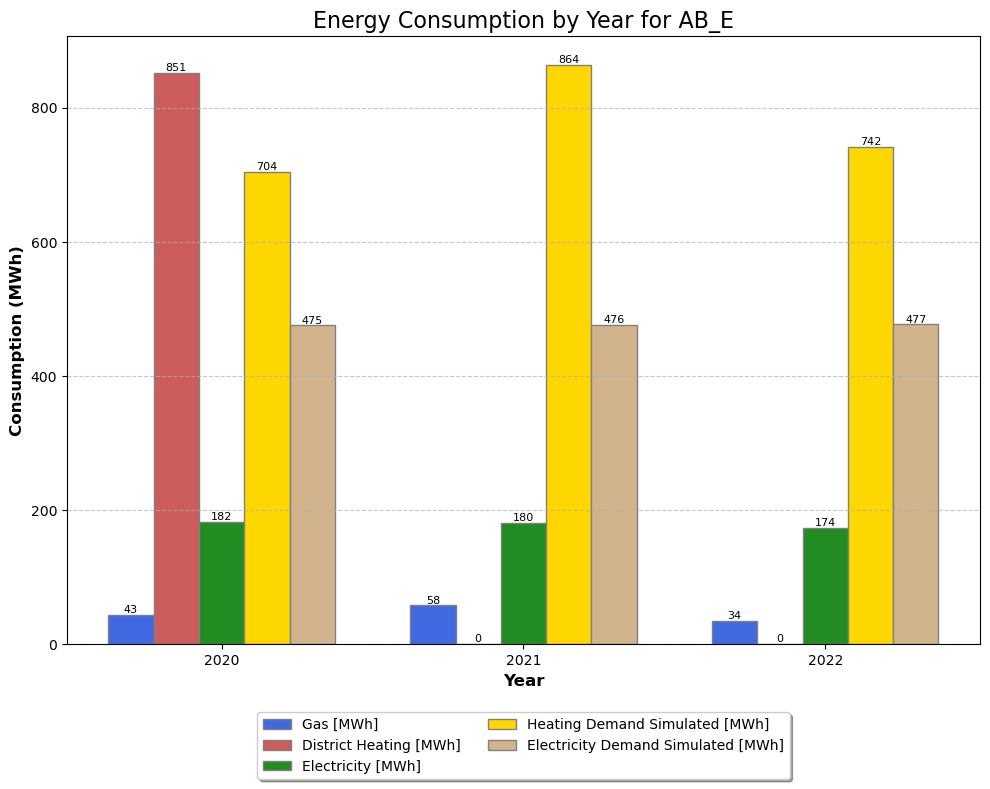

{'QH_sys_MWhyr': {2020: 138.395, 2021: 183.66899999999998, 2022: 153.662}, 'E_sys_MWhyr': {2020: 487.55400000000003, 2021: 486.697, 2022: 487.29699999999997}}


<Figure size 640x480 with 0 Axes>

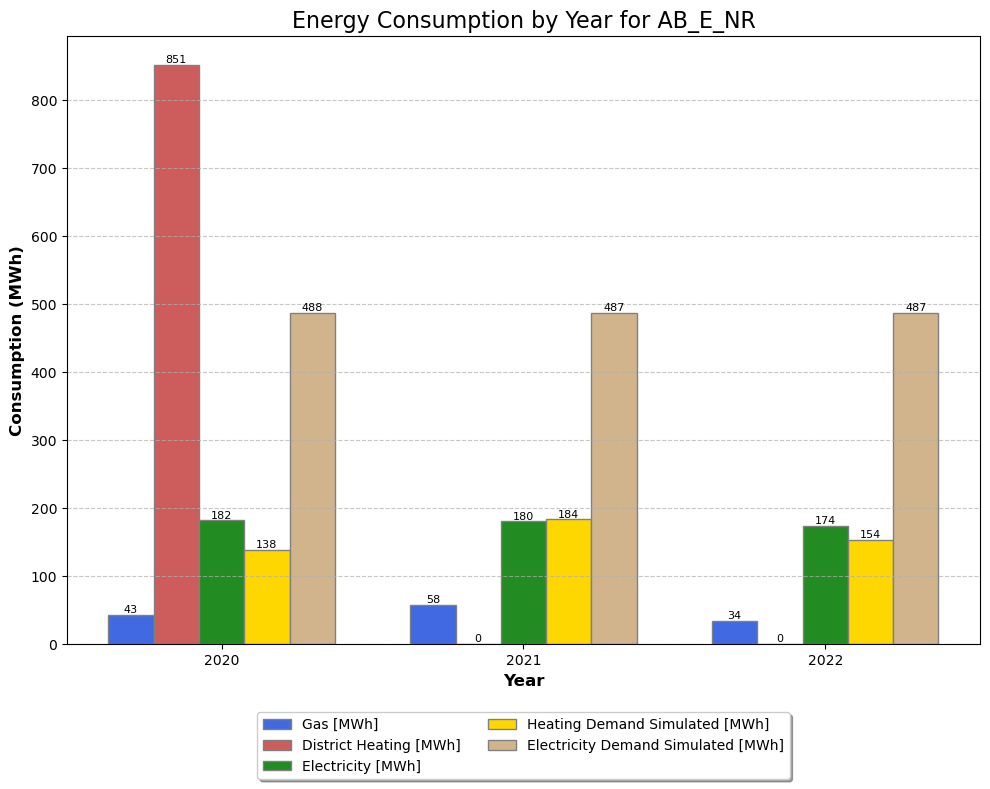

{'QH_sys_MWhyr': {2020: 89.253, 2021: 115.96000000000001, 2022: 97.49300000000001}, 'E_sys_MWhyr': {2020: 489.53799999999995, 2021: 488.7960000000001, 2022: 489.698}}


<Figure size 640x480 with 0 Axes>

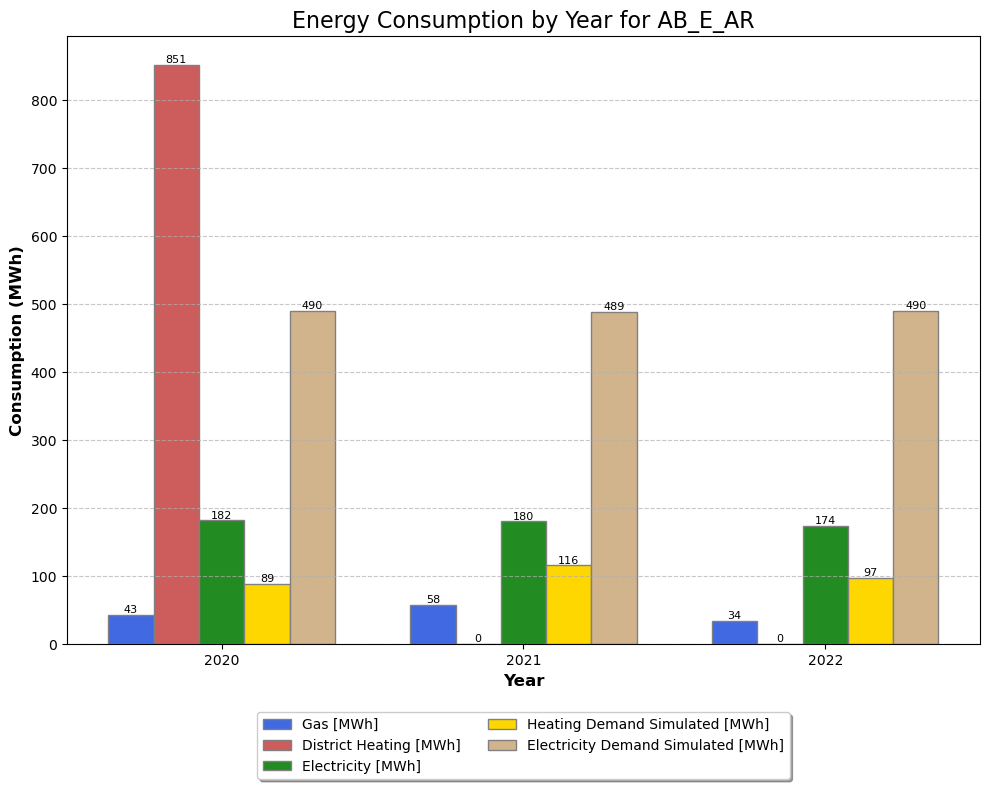

<Figure size 640x480 with 0 Axes>

In [28]:
# Get measured data 

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


wd_dir = os.getcwd()
gas_path = os.path.join(wd_dir, 'auxillary', 'Gas_Berlin_2020_2022.xls')
gas_data = pd.read_excel(gas_path)
gas_data_filtered = gas_data[gas_data["Blocknummer"] == 20023]
gas_mwhyr = {
    2020: gas_data_filtered["Gasverbrauch 2020 [MWh]"].item(),
    2021 : gas_data_filtered["Gasverbrauch 2021 [MWh]"].item(),
    2022: gas_data_filtered["Gasverbrauch 2022 [MWh]"].item()
}
elec_path = os.path.join(wd_dir, 'auxillary', 'Elec_Berlin_2020_2022.xls')
elec_data = pd.read_excel(elec_path)
elec_data_filtered = elec_data[elec_data["Blocknummer"] == 20023]
elec_mwhyr = {
    2020: elec_data_filtered["Stromverbrauch 2020 [MWh]"].item(),
    2021 : elec_data_filtered["Stromverbrauch 2021 [MWh]"].item(),
    2022: elec_data_filtered["Stromverbrauch 2022 [MWh]"].item()
}
elec_mwhyr

dh_path = os.path.join(wd_dir, 'auxillary', 'DH_Berlin_2020_2022.xls')
dh_data = pd.read_excel(dh_path)
dh_data_filtered = dh_data[dh_data["Blocknummer"] == 20023]
dh_data_filtered = dh_data_filtered.replace('-', 0)
dh_mwhyr = {
    2020: dh_data_filtered["Fernwärmeverbrauch 2020 [MWh]"].item(),
    2021 : dh_data_filtered["Fernwärmeverbrauch 2021 [MWh]"].fillna(0).item(),
    2022: dh_data_filtered["Fernwärmeverbrauch 2022 [MWh]"].fillna(0).item()

} 


for archetype in archetypes:
    data_dict = {
    "QH_sys_MWhyr": {},
    "E_sys_MWhyr": {}}
    for year in years: 
        path_to_scenario_data = os.path.join(project_folder, 'Block0202023', f'{year}_{archetype}', 'outputs', 'data', 'demand', 'Total_demand.csv') 
        df = pd.read_csv(path_to_scenario_data)
        data_dict["QH_sys_MWhyr"][year] = df["QH_sys_MWhyr"].sum()
        data_dict["E_sys_MWhyr"][year] = df["E_sys_MWhyr"].sum()
    
    
    print(data_dict)
    # Assume the dictionaries 'gas_mwhyr', 'dh_mwhyr', 'elec_mwhyr' and 'data_dict' are already defined as in the original scenario.

    # Years for the x-axis
    years = list(gas_mwhyr.keys())

    # Values for the y-axis
    gas_values = list(gas_mwhyr.values())
    dh_values = list(dh_mwhyr.values())
    elec_values = list(elec_mwhyr.values())
    sim_heating = list(data_dict["QH_sys_MWhyr"].values())
    sim_elec = list(data_dict["E_sys_MWhyr"].values())

    # Set the width of the bars
    bar_width = 0.15  # Reduced width to introduce space between bars

    # Set the position of the bars on the x-axis
    r1 = np.arange(len(gas_values))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]
    r4 = [x + bar_width for x in r3]
    r5 = [x + bar_width for x in r4]

    # Make the plot
    plt.figure(figsize=(10, 8))  # Increased figure size
    plt.bar(r1, gas_values, color='royalblue', width=bar_width, edgecolor='grey', label='Gas [MWh]')
    plt.bar(r2, dh_values, color='indianred', width=bar_width, edgecolor='grey', label='District Heating [MWh]')
    plt.bar(r3, elec_values, color='forestgreen', width=bar_width, edgecolor='grey', label='Electricity [MWh]')
    plt.bar(r4, sim_heating, color='gold', width=bar_width, edgecolor='grey', label='Heating Demand Simulated [MWh]')
    plt.bar(r5, sim_elec, color='tan', width=bar_width, edgecolor='grey', label='Electricity Demand Simulated [MWh]')

    # Add labels to the x-axis and y-axis
    plt.xlabel('Year', fontweight='bold', fontsize=12)
    plt.ylabel('Consumption (MWh)', fontweight='bold', fontsize=12)
    plt.xticks([r + bar_width*2 for r in range(len(gas_values))], years, fontsize=10)

    # Create legend & Show graphic
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), shadow=True, ncol=2)
    plt.title(f'Energy Consumption by Year for {archetype}', fontsize=16)

    # Add grid
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Optionally, add value labels on top of each bar
    for i in range(len(r1)):
        plt.text(r1[i], gas_values[i], str(round(gas_values[i])), ha='center', va='bottom', fontsize=8)
        plt.text(r2[i], dh_values[i], str(round(dh_values[i])), ha='center', va='bottom', fontsize=8)
        plt.text(r3[i], elec_values[i], str(round(elec_values[i])), ha='center', va='bottom', fontsize=8)
        plt.text(r4[i], sim_heating[i], str(round(sim_heating[i])), ha='center', va='bottom', fontsize=8)
        plt.text(r5[i], sim_elec[i], str(round(sim_elec[i])), ha='center', va='bottom', fontsize=8)

    # Show graphic
    plt.tight_layout()  # Adjust the padding between and around subplots.
    plt.show()
    save_path = os.path.join(wd_dir, 'plots', f'{year}_{archetype}_1' )
    plt.savefig(save_path)